In [21]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load

In [22]:
repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [23]:
data_dir_grat = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1372_220714_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(data_dir_grat, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
len(stim_id), np.unique(stim_id), trace_by_trial.shape

ncell: 56, nstim: 1, ntrial: 219, nframe: 267


(219, array([0], dtype=uint8), (56, 219, 267))

In [31]:
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

trace_cell_avg: (267,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (267,)


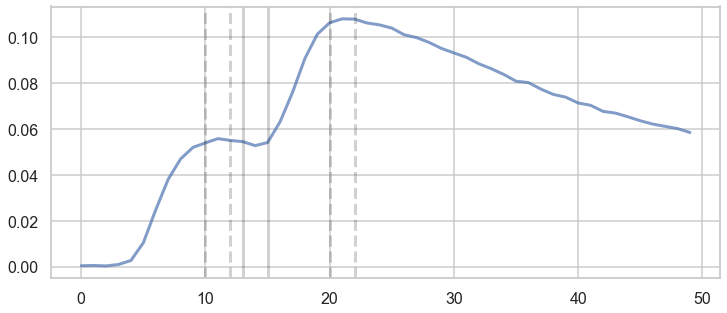

In [50]:
plt.figure(figsize=(12, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
plt.axvline(x=10, color='k', linestyle='--', linewidth=3, alpha=0.2)
plt.axvline(x=12, color='k', linestyle='--', linewidth=3, alpha=0.2)

plt.axvline(x=13, color='k', linestyle='-', linewidth=3, alpha=0.2)
plt.axvline(x=15, color='k', linestyle='-', linewidth=3, alpha=0.2)

plt.axvline(x=20, color='k', linestyle='--', linewidth=3, alpha=0.2)
plt.axvline(x=22, color='k', linestyle='--', linewidth=3, alpha=0.2)

# adp
estimate how many trials to group together to get a stable adaptation value  
1. trace_by_trial shape: ncell x ntrial x nframe  
2. for each cell x trial, get resp_ad and resp_tg  
3. for whole population, loop thru trial numbers to group together to get a stable adaptation value  
3.1 measure adp value stability: plot group_size vs adp_mean & adp_std  
4. do this for each cell  
4.1 distribution of stable_group_size among cells  

In [88]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2)
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad_pop = resp_ad.mean(axis=0)
resp_tg_pop = resp_tg.mean(axis=0)
adp = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
np.mean(adp), np.mean(adp_IOU)

(-0.15452593085169297, -0.03254494106556187)

## pop adp stability

In [126]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_mean = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2): # >= 4 groups
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group_mean = np.mean(resp_ad_cut, axis=1)
    resp_tg_group_mean = np.mean(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group_mean - resp_ad_group_mean) / (resp_ad_group_mean + 1e-7)
    adp_group_mean = np.mean(adp_group)
    adp_group_std = np.std(adp_group)
    # print(f'group_size: {group_size}, ngroup: {ngroup}, adp_group_std: {adp_group_std}')
    adp_mean.append(adp_group_mean)
    adp_std.append(adp_group_std)

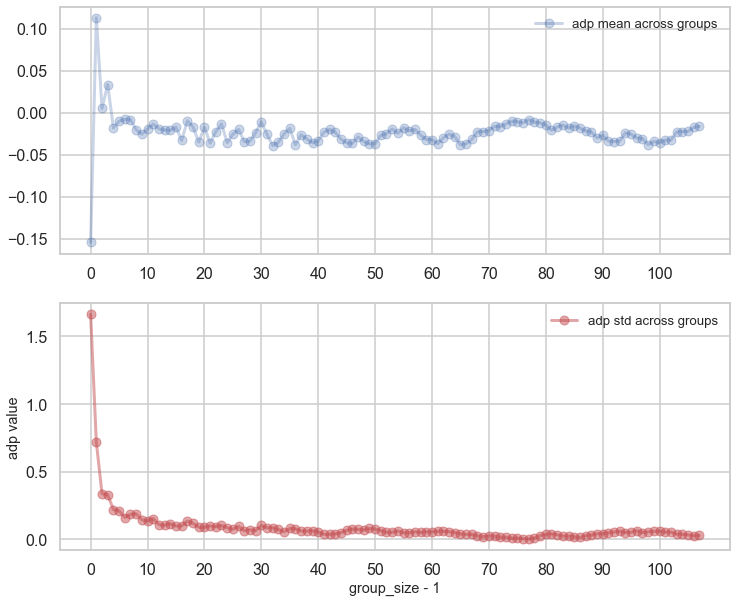

In [178]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_mean, 'o-', color='b', linewidth=3, alpha=0.3, label='adp mean across groups')
plt.xticks(np.arange(0,110,10))
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
# plt.yscale('log')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
plt.ylabel('adp value')
plt.legend(frameon=False);

## single cell adp stability

In [164]:
ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_mean = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
    # for group_size in np.arange(1, trace_by_trial.shape[1] // ngroup_min):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group_mean = np.mean(resp_ad_cut, axis=1)
        resp_tg_group_mean = np.mean(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group_mean - resp_ad_group_mean) / (resp_ad_group_mean + 1e-7)
        adp_group_mean = np.mean(adp_group)
        adp_group_std = np.std(adp_group)
        adp_cell_mean[icell, isize] = adp_group_mean
        adp_cell_std[icell, isize] = adp_group_std

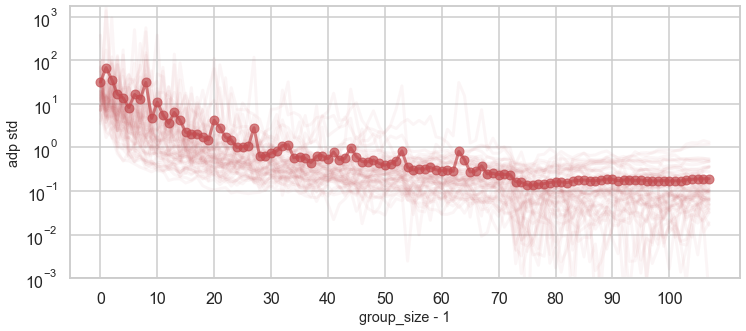

In [177]:
adp_cell_std_mean = adp_cell_std.mean(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_mean, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups avg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
plt.yscale('log')
plt.ylabel('adp std');

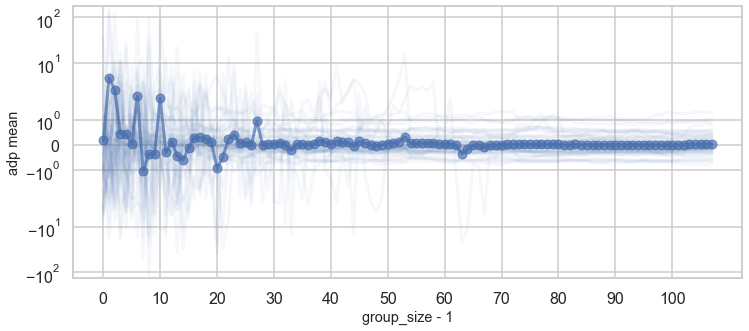

In [175]:
adp_cell_mean_mean = adp_cell_mean.mean(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_mean_mean, 'o-', color='b', linewidth=3, alpha=0.7, label='adp mean across groups avg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_mean[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp mean across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
plt.ylabel('adp mean');